# Data Mining - Project
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_source = pd.read_csv('donors.csv')
df_source.drop('Unnamed: 0', axis = 1, inplace = True)

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9,412) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df_source.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,,,,XXXX,T2,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0,39,34,18,10,2,1,,,,5.0,,,,,,,,,,,,,,,,,,,,,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,2017-06-01,2016-06-01,2016-04-01,2016-04-01,2016-03-01,2016-02-01,20

In [5]:
def splitNumericAndCategorical(df):
    """Informs user on the total number of columns in the dataframe and splits it
       in 2 dataframes, one numerical and the other categorical."""
    df_num = df._get_numeric_data()
    df_cat = df.drop(df_num.columns, axis = 1)
    print(f"Total Columns: {df.shape[1]}")
    print(f"Numerical Columns: {df_num.shape[1]}")
    print(f"Categorical Columns: {df_cat.shape[1]}")
    return df_num,df_cat

In [6]:
df_numeric, df_categorical = splitNumericAndCategorical(df_source)

Total Columns: 475
Numerical Columns: 350
Categorical Columns: 125


# Drop columns which are not relevant for the analysis

In [7]:
df_aux1 = pd.DataFrame()

with open('ColumnsToKeep.txt','r') as fp:
    ColumnsToKeep = [line.strip() for line in fp.readlines()]

for column in ColumnsToKeep:
    df_aux1[column] = df_source[column]

In [8]:
df_numeric, df_categorical = splitNumericAndCategorical(df_aux1)

Total Columns: 341
Numerical Columns: 311
Categorical Columns: 30


# Prepare data

In [9]:
df_aux2 = df_aux1.copy()

## Cast dates to datetime object + create variables

In [10]:
DateColumns = ['DOB','MAXADATE','MINRDATE','MAXRDATE','LASTDATE','FISTDATE','NEXTDATE']

for column in DateColumns:
    df_aux2[column] = pd.to_datetime(df_aux1[column])

In [11]:
# Computing AGE from DOB
df_aux2['AGE'] = (pd.Timestamp('now') - df_aux2['DOB']).astype('<m8[Y]')
df_aux2.drop('DOB', axis = 1, inplace = True)

# Computing number of days elapsed from each date variable
DateColumns = ['MAXADATE','MINRDATE','MAXRDATE','LASTDATE','FISTDATE','NEXTDATE']
for column in DateColumns:
    df_aux2[f'elapsed_{column}'] = (pd.Timestamp('now') - df_aux2[column]).dt.days
    
df_aux2.drop(DateColumns, axis = 1, inplace = True)

## Create Binary Variables based on the flags

In [12]:
df_aux3 = df_aux2.copy()

In [13]:
df_aux3['PVASTATE'] = df_aux2['PVASTATE'].apply(lambda x: 1 if ( (x == 'E') or (x == 'P')) else 0)
df_aux3['NOEXCH'  ] = df_aux2['NOEXCH'  ].apply(lambda x: 0 if ( (x == 'X') ) else 1)
df_aux3['HOMEOWNR'] = df_aux2['HOMEOWNR'].apply(lambda x: 0 if ( (x == 'H') ) else 1)
df_aux3['VETERANS'] = df_aux2['VETERANS'].apply(lambda x: 0 if ( (x == 'Y') ) else 1)
df_aux3['RECINHSE'] = df_aux2['RECINHSE'].apply(lambda x: 1 if ( (x == 'X') ) else 0)
df_aux3['RECP3'   ] = df_aux2['RECP3'   ].apply(lambda x: 1 if ( (x == 'X') ) else 0)
df_aux3['RECPGVG' ] = df_aux2['RECPGVG' ].apply(lambda x: 1 if ( (x == 'X') ) else 0)
df_aux3['RECSWEEP'] = df_aux2['RECSWEEP'].apply(lambda x: 1 if ( (x == 'X') ) else 0)
df_aux3['MAJOR'   ] = df_aux2['MAJOR'   ].apply(lambda x: 1 if ( (x == 'X') ) else 0)
df_aux3['PEPSTRFL'] = df_aux2['PEPSTRFL'].apply(lambda x: 1 if ( (x == 'X') ) else 0)

## Fixes issues identified in some columns

In [14]:
df_aux4 = df_aux3.copy()

In [15]:
df_aux4['ZIP'] = df_aux3['ZIP'].str.replace('-','').astype(int)
df_aux4['GENDER'] = df_aux3['GENDER'].apply(lambda x: 1 if (x == 'F') else 2 if (x == 'M') else 0)
df_aux4['DATASRCE'] = df_aux3['DATASRCE'].apply(lambda x: 0 if (x == ' ') else int(x))
df_aux4['SOLP3'] = df_aux3['SOLP3'].apply(lambda x: 12 if (x == ' ') else int(x))
df_aux4['SOLIH'] = df_aux3['SOLIH'].apply(lambda x: 12 if (x == ' ') else int(x))
df_aux4['GEOCODE'] = df_aux3['GEOCODE'].apply(lambda x: 0 if (x == ' ') else int(x))

## Handle Domain, RFA, MDAUD Columns

In [16]:
df_aux5 = df_aux4.copy()

### Domain

In [17]:
# DOMAIN handling
# 1st byte = Urbanicity level of the donor's neighborhood
#     U=Urban=5
#     C=City=4
#     S=Suburban=3
#     T=Town=2
#     R=Rural=1

# 2nd byte = Socio-Economic status of the neighborhood
#     1 = Highest SES
#     2 = Average SES
#     3 = Lowest SES 
#     (except for Urban communities, where
#       1 = Highest SES, 
#       2 = Above average SES,
#       3 = Below average SES, 
#       4 = Lowest SES.)

def prepURBANICITY(Code):
    if Code == ' ':
        return 0 #Empty
    else:
        if Code[0] == 'R':
            return 1
        elif Code[0] == 'T':
            return 2
        elif Code[0] == 'S':
            return 3
        elif Code[0] == 'C':
            return 4
        elif Code[0] == 'U':
            return 5
        else:
            return 0
        
def prepSOCIOECON(Code):
    if Code == ' ':
        return 0 #Empty
    else:
        if (Code[0] == 'R') or (Code[0] == 'T') or (Code[0] == 'S') or Code[0] == 'C':
            if Code[1] == '1':
                return 1
            elif Code[1] == '2':
                return 3
            elif Code[1] == '3':
                return 5
            else:
                return 0
        elif Code[0] == 'U':
            if Code[1] == '1':
                return 1
            elif Code[1] == '2':
                return 2
            elif Code[1] == '3':
                return 4
            elif Code[1] == '4':
                return 5
            else:
                return 0
        else:
            return 0

df_aux5['URBANICITY'] = df_aux4['DOMAIN'].apply(prepURBANICITY)
df_aux5['SOCIOECON' ] = df_aux4['DOMAIN'].apply(prepSOCIOECON)
df_aux5.drop('DOMAIN', axis = 1, inplace = True)

### RFA

In [18]:
def prepLASTGIFTAMOUNTCATEGORY(Code):
    if Code == ' ':
        return 0 #Empty
    else:
        if Code[0] == 'A':
            return 1
        elif Code[0] == 'B':
            return 2
        elif Code[0] == 'C':
            return 3
        elif Code[0] == 'D':
            return 4
        elif Code[0] == 'E':
            return 5
        elif Code[0] == 'F':
            return 6
        elif Code[0] == 'G':
            return 7
        else:
            return 0
        
df_aux5['LASTGIFTAMOUNTCATEGORY'] = df_aux4['RFA_2A'].apply(prepLASTGIFTAMOUNTCATEGORY)
df_aux5.drop('RFA_2A', axis = 1, inplace = True)
df_aux5.drop('RFA_2R', axis = 1, inplace = True) # all donors are lapsing donors

### MDAUD

In [19]:
def prepMDONOR_GIVING_RECENCY(Code):
    if Code[0] == 'X':
        return 0 # Not a major donor
    else:
        if Code[0] == 'C':
            return 1
        elif Code[0] == 'L':
            return 2
        elif Code[0] == 'I':
            return 3
        elif Code[0] == 'D':
            return 4
        else:
            return 0
    
def prepMDONOR_GIVING_FREQUENCY(Code):
    if Code[0] == 'X':
        return 0 # Not a major donor
    else:
        if Code[0] == '1':
            return 1
        elif Code[0] == '2':
            return 2
        elif Code[0] == '5':
            return 3
        else:
            return 0
        
def prepMDONOR_GIVING_AMOUNT(Code):
    if Code[0] == 'X':
        return 0 # Not a major donor
    else:
        if Code[0] == 'L':
            return 1
        elif Code[0] == 'C':
            return 2
        elif Code[0] == 'M':
            return 3
        elif Code[0] == 'T':
            return 4
        else:
            return 0
        
df_aux5['MDONOR_GIVING_RECENCY'] = df_aux4['MDMAUD_R'].apply(prepMDONOR_GIVING_RECENCY)
df_aux5['MDONOR_GIVING_FREQUENCY'] = df_aux4['MDMAUD_F'].apply(prepMDONOR_GIVING_FREQUENCY)
df_aux5['MDONOR_GIVING_AMOUNT'] = df_aux4['MDMAUD_A'].apply(prepMDONOR_GIVING_AMOUNT)

df_aux5.drop('MDMAUD_R', axis = 1, inplace = True)
df_aux5.drop('MDMAUD_F', axis = 1, inplace = True)
df_aux5.drop('MDMAUD_A', axis = 1, inplace = True)

In [20]:
df_numeric, df_categorical = splitNumericAndCategorical(df_aux5)

Total Columns: 341
Numerical Columns: 340
Categorical Columns: 1


# Scaling the data

In [21]:
df_scaling = df_aux5.copy()

In [22]:
df_numeric, df_categorical = splitNumericAndCategorical(df_scaling)

Total Columns: 341
Numerical Columns: 340
Categorical Columns: 1


In [23]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaling[df_numeric.columns] = scaler.fit_transform(df_numeric)

# Reduce Dimensionality

In [24]:
# https://www.kdnuggets.com/2015/05/7-methods-data-dimensionality-reduction.html

In [25]:
df_FEreduction = df_scaling.copy()

## Drop columns based on valid observations

In [26]:
df_numeric, df_categorical = splitNumericAndCategorical(df_FEreduction)

Total Columns: 341
Numerical Columns: 340
Categorical Columns: 1


In [27]:
import math

ThresholdToIgnore = 0.4 # If more than 40% of the dataset is missing

MinimumValidSamples = math.floor(df_FEreduction.shape[0] * ThresholdToIgnore)
print(f"Minimum Valid Samples: {MinimumValidSamples}")
for column in df_FEreduction.columns:
    count = df_FEreduction[column].count()
    #print(f"{column}:{count}")
    if count < MinimumValidSamples:
        print(f"Dropped {column} , Valid Observations: {count}")
        df_FEreduction.drop(column,axis=1, inplace=True)

Minimum Valid Samples: 38164
Dropped NUMCHLD , Valid Observations: 12386


## Drop columns with high/low correlation

In [28]:
df_numeric, df_categorical = splitNumericAndCategorical(df_FEreduction)

Total Columns: 340
Numerical Columns: 339
Categorical Columns: 1


In [29]:
corPearson = df_numeric.corr().abs()

# Select upper triangle of correlation matrix
upper = corPearson.where(np.triu(np.ones(corPearson.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90 and lower than 0.3
HighCorrelation = [column for column in upper.columns if any(upper[column] > 0.90)]
LowCorrelation = [column for column in upper.columns if max(upper[column]) < 0.20]

print(f"Dropping {len(HighCorrelation)} columns with High correlation.")
print(f"Dropping {len(LowCorrelation)} columns with Low correlation.")

# Drop features 
df_FEreduction.drop(HighCorrelation, axis=1, inplace=True)
df_FEreduction.drop(LowCorrelation, axis=1, inplace=True)

Dropping 66 columns with High correlation.
Dropping 30 columns with Low correlation.


## Drop columns with low variance

In [30]:
df_numeric, df_categorical = splitNumericAndCategorical(df_FEreduction)

Total Columns: 244
Numerical Columns: 243
Categorical Columns: 1


In [31]:
VarianceThreshold = 0.005

for column in df_numeric:
    var = df_FEreduction[column].var()
    if VarianceThreshold > var:
        print(f"Dropped {column} , Variance: {var}")
        df_FEreduction.drop(column,axis=1,inplace=True)

Dropped ETH6 , Variance: 0.003813343269872504
Dropped ETH7 , Variance: 0.003844572899357172
Dropped ETH8 , Variance: 0.0026200820042238814
Dropped ETH9 , Variance: 0.004751550371007165
Dropped ETH10 , Variance: 0.001903727204597813
Dropped ETH11 , Variance: 0.00201207974637391
Dropped ETH12 , Variance: 0.0010556568291769696
Dropped ETH14 , Variance: 0.0020577221185914003
Dropped HHD8 , Variance: 0.002021027601848559
Dropped ETHC6 , Variance: 0.0034788809233272065
Dropped RHP4 , Variance: 0.003498429401515511
Dropped HUPA7 , Variance: 0.0037265213687236657
Dropped IC13 , Variance: 0.003975778425846497
Dropped TPE5 , Variance: 0.0038331966102909364
Dropped TPE6 , Variance: 0.0009775795956356058
Dropped OCC3 , Variance: 0.0026854822376925196
Dropped OCC6 , Variance: 0.0021417841717928363
Dropped OCC7 , Variance: 0.004699896418342247
Dropped OCC12 , Variance: 0.004239876371784107
Dropped OCC13 , Variance: 0.0036243906469866365
Dropped EIC5 , Variance: 0.004183862269308264
Dropped EIC7 , Va

## PCA on the Neighborhood data

In [32]:
df_NB = df_FEreduction.copy()

In [33]:
df_numeric, df_categorical = splitNumericAndCategorical(df_NB)

Total Columns: 202
Numerical Columns: 201
Categorical Columns: 1


In [34]:
with open('NeighborhoodColumns.txt','r') as fp:
    NeighborhoodColumns = [line.strip() for line in fp.readlines()]

df_NB_aux = pd.DataFrame()

for column in NeighborhoodColumns:
    if column in df_NB.columns:
        df_NB_aux[column] = df_NB[column]
        
print(f"Neighborhood data has {df_NB_aux.shape[1]} columns.")

Neighborhood data has 177 columns.


In [35]:
# Populating missing values of the Neighborhood data
for column in df_NB_aux:
    df_NB_aux.fillna(df_NB_aux[column].mean(),inplace=True)

In [36]:
df_NB_aux.head()

,POP90C1,POP90C2,POP90C3,POP90C5,ETH1,ETH2,ETH4,ETH5,ETH15,ETH16,AGE901,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE2,HHN1,HHN2,HHN3,HHN5,MARR1,MARR2,MARR4,DW1,DW3,DW4,DW7,DW8,DW9,HV1,HV3,HU1,HU3,HU4,HU5,HHD2,HHD6,HHD7,HHD10,HHD12,ETHC1,ETHC2,ETHC3,HVP3,HVP5,HUR1,HUR2,HUPA1,HUPA3,HUPA4,HUPA5,RP3,RP4,MSA,ADI,DMA,IC1,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC14,IC15,IC16,IC17,IC18,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE8,TPE9,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC4,OCC5,OCC8,OCC9,OCC10,OCC11,EIC3,EIC4,EIC8,EIC9,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC4,AFC6,VC1,VC2,VC3,VC4,ANC2,ANC4,ANC8,ANC14,POBC1,POBC2,LSC1,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC9,HC10,HC11,HC12,HC13,HC14,HC16,HC17,HC19,HC20,HC21,MHUC1,MHUC2
0,-1.0,-0.292929,0.313131,0.070707,0.858586,-0.979798,-1.000000,-0.777778,-1.000000,-1.000000,-0.071429,-0.333333,-0.373737,-0.151515,-0.454545,-0.777778,-0.717172,-0.636364,-0.656566,-0.737374,-0.777778,-0.696970,-0.757576,-0.777778,-0.313131,-0.494949,-0.636364,-0.797980,-0.636364,-0.333333,-0.010101,-0.757576,0.232323,-0.858586,-0.616162,0.959596,-0.959596,-0.959596,-0.858586,-0.858586,-1.000000,-0.840333,-0.538462,0.737374,0.939394,-0.919192,-0.858586,0.616162,-0.676768,-0.878788,-0.818182,-0.939394,-0.546667,0.010101,-0.494949,-0.737374,-0.050505,-0.979798,0.232323,-0.959596,-1.000000,-0.717172,-0.979798,-0.656566,0.474747,-1.000000,-0.456221,0.548241,-0.590667,-0.852363,-0.737374,-0.535354,-0.535354,-0.535354,-0.696970,-0.979798,-1.00,-0.979798,-0.919192,-0.494949,-0.515152,-0.474747,-0.919192,0.030303,-0.979798,-0.070707,0.090909,-0.939394,0.777778,-0.838384,-1.000000,-1.000000,-0.919192,-0.737374,-0.688889,-0.578947,-0.959596,-0.090909,0.131313,0.252525,0.070707,1.000000,-1.0,-1.000000,-0.818182,-0.939394,-0.737374,-0.818182,-0.818182,-0.939394,-0.696970,-0.616162,-0.939394,-0.171717,-0.737374,-0.878788,-0.818182,-0.919192,-0.979798,-0.939394,-0.797980,-0.959596,-0.979798,-0.858586,0.575758,-0.959596,0.411765,-0.676768,-0.797980,-0.212121,-0.575758,-0.567568,-0.919192,-0.939394,-0.896907,-0.595960,-0.800000,-0.472222,-0.919192,-0.636364,-1.000000,-0.313131,-0.535354,-0.636364,-0.676768,-0.919192,-0.500000,-0.963636,-0.851852,-0.939394,0.494949,0.777778,-1.000000,-0.919192,0.939394,0.555556,-0.616162,-0.161290,0.192308,-0.898990,-0.717172,-0.717172,-0.373737,0.090909,-1.0,-1.0,0.818182,-1.000000,-0.797980,-1.000000,-1.000000,-0.333333,-0.191919,1.000000,1.000000,-0.428571,-0.2
1,1.0,-1.000000,-1.000000,0.010101,0.353535,-1.000000,-0.373737,-0.878788,-0.975309,-0.906977,-0.190476,-0.146667,-0.333333,-0.070707,-0.575758,-0.737374,-0.717172,-0.333333,-0.535354,-0.797980,-0.919192,-0.959596,-0.777778,-0.676768,-0.272727,-0.555556,-0.696970,-0.979798,-0.919192,-0.575758,0.515152,-0.535354,0.393939,-0.919192,-0.515152,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.822667,0.846154,0.939394,0.959596,-0.939394,-0.818182,0.898990,-0.898990,-0.919192,-0.898990,-0.959596,-0.520000,-0.111111,-0.898990,0.979798,1.000000,-1.000000,0.676768,-1.000000,-1.000000,-0.919192,-1.000000,0.838384,0.898990,-0.042735,-0.960061,0.822928,0.450667,-0.585441,-0.959596,-0.878788,-0.959596,-0.898990,-0.696970,-0.717172,-0.48,-0.333333,-0.959596,-0.898990,-0.959596,-0.898990,-0.959596,0.333333,-0.939394,0.131313,-0.111111,-0.818182,0.616162,-0.717172,-1.000000,-1.000000,-0.878788,-0.959596,-0.466667,-0.157895,-0.757576,0.434343,0.414141,0.292929,0.151515,1.000000,1.0,-1.000000,-0.555556,-0.515152,-0.575758,-0.737374,-0.878788,-1.000000,-0.919192,-0.979798,-0.878788,-0.737374,-0.636364,-0.777778,-0.797980,-0.858586,-0.777778,-0.979798,-0.878788,-0.959596,-0.979798,-0.676768,0.393939,-0.898990,0.882353,-0.898990,-0.898990,-0.757576,-0.575758,-0.621622,-0.393939,-0.595960,-0.711340,-0.515152,-0.733333,-0.333333,-0.797980,-0.838384,-1.000000,0

The first 15 Components of PCA can explain 0.7890623879008858 of the subset of the data


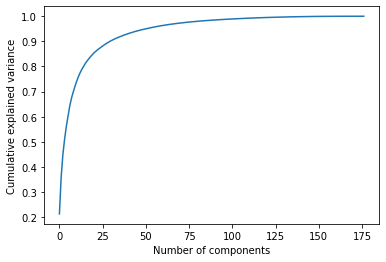

In [37]:
pca = PCA(n_components=None) # apply PCA to create as many components as features
pca.fit(df_NB_aux)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

print(f"The first 15 Components of PCA can explain {sum(pca.explained_variance_ratio_[0:14])} of the subset of the data")

In [38]:
pca = PCA(n_components=15) # 
pca.fit(df_NB_aux)

columnsPCA = [f"NB_PCA_{i}" for i in range(1,16)]
df_NB_PCA = pd.DataFrame(pca.transform(df_NB_aux),columns=columnsPCA)

In [39]:
df_NB.drop(df_NB_aux.columns, axis = 1, inplace = True)
df_NB[columnsPCA] = df_NB_PCA

In [40]:
df_numeric, df_categorical = splitNumericAndCategorical(df_NB)

Total Columns: 40
Numerical Columns: 39
Categorical Columns: 1


## Missing Values

In [41]:
df_MV = df_NB.copy()

In [42]:
df_numeric, df_categorical = splitNumericAndCategorical(df_MV)

Total Columns: 40
Numerical Columns: 39
Categorical Columns: 1


In [43]:
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
df_MV[df_numeric.columns] = pd.DataFrame(imputer.fit_transform(df_numeric))

## Outlier Removal

In [44]:
df_outlier = df_MV.copy()

In [45]:
df_numeric, df_categorical = splitNumericAndCategorical(df_outlier)

Total Columns: 40
Numerical Columns: 39
Categorical Columns: 1


In [46]:
from sklearn.ensemble import IsolationForest

IsoForest = IsolationForest(contamination=0.1)

Labeling = IsoForest.fit_predict(df_numeric)

Labeling_bool = [True if x == 1 else False for x in Labeling]

df_outlier = df_outlier.loc[Labeling_bool]

In [76]:
df_source['GEOCODE'].value_counts()

      80168
12     3914
03     3327
14     2017
05     1918
04     1622
02     1408
01     1038
Name: GEOCODE, dtype: int64

In [47]:
df_outlier

,STATE,ZIP,RECSWEEP,INCOME,WEALTH1,DATASRCE,WWIIVETS,LOCALGOV,FEDGOV,SOLIH,MAJOR,WEALTH2,GEOCODE,CARDPROM,CARDPM12,NUMPRM12,NGIFTALL,RFA_2F,AGE,elapsed_MINRDATE,elapsed_MAXRDATE,elapsed_LASTDATE,URBANICITY,SOCIOECON,LASTGIFTAMOUNTCATEGORY,NB_PCA_1,NB_PCA_2,NB_PCA_3,NB_PCA_4,NB_PCA_5,NB_PCA_6,NB_PCA_7,NB_PCA_8,NB_PCA_9,NB_PCA_10,NB_PCA_11,NB_PCA_12,NB_PCA_13,NB_PCA_14,NB_PCA_15
0,IL,0.215948,-1.0,-0.466667,0.066667,-1.0,-0.636364,-0.797980,-0.977011,1.0,-1.0,0.111111,-1.000000,-0.133333,-0.368421,-0.662338,-0.745763,1.000000,0.379310,-0.584386,-0.718758,0.217639,-0.2,0.2,-0.333333,1.856357,-0.012830,-1.635794,0.897430,0.634637,0.221922,0.375212,-0.912251,0.242031,0.181477,-0.178029,0.481376,-0.206783,-0.219512,0.018420
1,CA,0.826040,-1.0,0.666667,1.000000,1.0,-0.777778,-0.878788,-0.977011,1.0,-1.0,1.000000,-0.714286,-0.633333,-0.368421,-0.688312,-0.983051,-0.333333,0.034483,-0.692016,-0.890172,0.217639,0.2,-0.6,1.000000,-2.712674,-2.456682,-0.872518,-0.405014,-0.890365,-0.592382,1.525164,0.446113,-0.285486,-0.010635,-1.219645,-0.139364,0.348619,-0.305678,-0.424149
2,NC,-0.471180,-1.0,-0.333333,-0.777778,1.0,-0.333333,-0.878788,-0.977011,1.0,-1.0,-0.777778,-1.000000,-0.166667,-0.368421,-0.662338,-0.779661,1.000000,0.098851,-0.515159,-0.569926,0.217639,-0.6,0.2,-0.333333,3.192268,-0.735119,0.043312,-0.364969,-0.522336,-0.194831,-0.741846,-0.419656,0.102598,0.149740,-0.255990,-0.359866,-0.041979,0.144349,-0.194829
3,CA,0.919374,-1.0,-1.000000,-0.111111,1.0,-0.373737,-0.939394,-0.931034,1.0,-1.0,-1.000000,-1.000000,-0.133333,-0.368421,-0.662338,-0.872881,1.000000,0.586207,-0.146033,-0.788812,0.217639,-0.6,0.2,-0.333333,1.863699,0.097747,0.098533,0.322401,-2.130365,-1.277251,0.785322,0.367090,-0.311283,-0.990166,0.988738,0.425790,0.903553,0.242935,-0.232013
5,AL,-0.297986,-1.0,-0.133333,0.600000,-1.0,-0.535354,-0.858586,-0.862069,1.0,-1.0,-0.111111,-1.000000,-0.533333,-0.368421,-0.714286,-0.974576,-1.000000,0.388506,-0.760990,-0.796510,0.738265,-0.2,0.2,0.333333,-0.063411,-1.137907,0.884392,-0.650841,0.136113,0.669722,-0.323504,0.096074,0.161088,0.006747,-0.075756,-0.792318,0.024899,0.197630,-0.036780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95405,CA,0.851355,-1.0,-0.600000,-0.688889,-1.0,0.393939,-0.858586,-0.977011,1.0,-1.0,-0.688889,-1.000000,-0.466667,-0.368421,-0.688312,-0.983051,-1.000000,0.517241,-0.861041,-0.796510,0.564723,0.6,1.0,1.000000,-0.261871,-0.372373,1.020237,0.568068,0.249635,0.420603,0.277136,0.718872,-1.184760,0.424309,-0.454489,1.554954,0.492576,-0.512866,-0.389696
95406,FL,-0.355011,-1.0,0.666667,0.333333,1.0,-0.070707,-0.494949,-0.977011,1.0,-1.0,0.333333,-1.000000,-0.266667,-0.473684,-0.714286,-0.805085,1.000000,0.126437,-0.907529,-0.444701,0.041252,0.2,0.2,-1.000000,2.256063,-2.209079,1.066132,-0.112572,-0.787688,-0.082776,-0.767795,-0.194132,0.547669,-0.322840,-0.064677,0.762481,-0.322331,0.384514,0.167885
95407,AK,0.991003,-1.0,0.266667,0.200000,-1.0,-0.777778,-0.858586,-0.701149,1.0,-1.0,0.155556,-1.000000,-0.833333,-0.473684,-0.714286,-1.000000,-1.000000,0.177011,-0.907529,-0.906082,0.041252,0.6,0.2,1.000000,-1.783702,-0.586193,0.374675,-0.856168,-0.089215,-0.190196,0.660586,-0.333776,-0.386904,0.799541,0.092138,-0.565931,-0.487632,-0.358900,-0.350763
95408,TX,0.544705,-1.0,1.000000,1.000000,1.0,-0.616162,-0.919192,-1.000000,1.0,-1.0,0.955556,-1.000000,-0.900000,-0.684211,-0.818182,-1.000000,-1.000000,0.080460,-0.914856,-0.913523,-0.041252,0.6,-0.6,0.333333,-1.435291,-2.251073,-0.273259,0.791204,0.153000,0.920647,1.525342,-0.658047,-0.579648,0.470275,-0.840849,-0.331268,1.097868,-0.429195,0.238644


## PCA on entire dataset

In [70]:
df_PCA = df_outlier.copy()

In [71]:
df_numeric, df_categorical = splitNumericAndCategorical(df_PCA)

Total Columns: 40
Numerical Columns: 39
Categorical Columns: 1


The first 10 Components of PCA can explain 0.7631371794669828 of the subset of the data


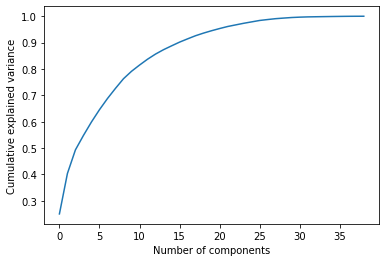

In [72]:
pca = PCA(n_components=None) # apply PCA to create as many components as features
pca.fit(df_numeric)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

print(f"The first 10 Components of PCA can explain {sum(pca.explained_variance_ratio_[0:9])} of the subset of the data")

In [73]:
pca = PCA(n_components=10) # 
pca.fit(df_numeric)

columnsPCA = [f"PCA_{i}" for i in range(1,11)]
df_PCA = pd.DataFrame(pca.transform(df_numeric),columns=columnsPCA)

# Clustering

In [52]:
df_clustering = df_PCA.copy()

In [53]:
df_numeric, df_categorical = splitNumericAndCategorical(df_clustering)

Total Columns: 10
Numerical Columns: 10
Categorical Columns: 0


In [54]:
def ClusterMetrics(df,labels):
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    
    Silhouette = silhouette_score(df, labels, metric='euclidean')
    print(f"Silhouette : {Silhouette}")
    CalinskiHarabasz = calinski_harabasz_score(df, labels)
    print(f"CalinskiHarabasz : {CalinskiHarabasz}")
    DaviesBouldin = davies_bouldin_score(df, labels)
    print(f"DaviesBouldin : {DaviesBouldin}")
    
    return [Silhouette, CalinskiHarabasz, DaviesBouldin]

In [55]:
def inertiaCalculationKmeans(df, numberClusters = range(1, 11)):
    inertiaResults = []
    for n_clus in numberClusters:
        kmclust = KMeans(n_clusters = n_clus, init = 'k-means++', n_init = 15, random_state=1)
        kmclust.fit(df)
        inertiaResults.append(kmclust.inertia_)
        
    plt.figure(figsize=(10,10))
    plt.plot(inertiaResults, color = 'g')
    plt.ylabel("Inertia")
    plt.xlabel("Number of clusters")
    plt.title("Inertia per clusters")
    plt.show()
    return inertiaResults

In [56]:
def tsneViz(df, labels = None,f_perplexity = 30.0, f_learning_rate = 200.0):
    from sklearn.manifold import TSNE
    import seaborn as sns
    
    tsne = TSNE(n_components=2, 
                perplexity = f_perplexity,
                learning_rate = f_learning_rate
               ).fit_transform(df)
    
    #plot tsne
    fig = plt.figure(figsize = (10, 10))
    sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=labels, legend='full', palette = "tab10")
    
    return tsne

## KMeans

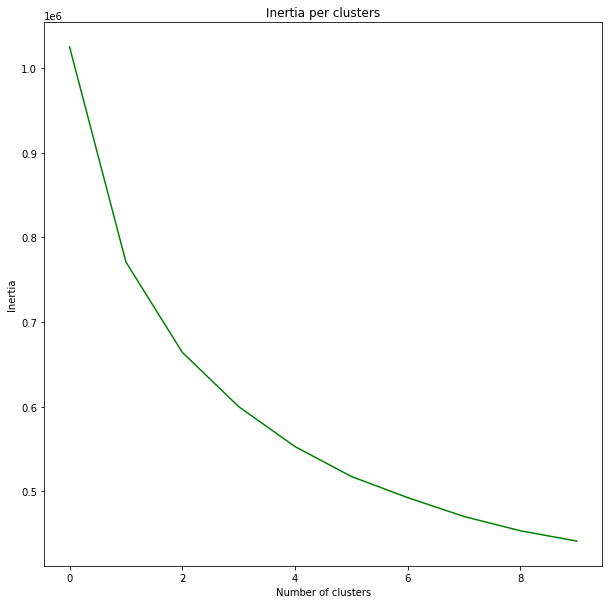

In [57]:
Inertia = inertiaCalculationKmeans(df_numeric)

In [74]:
KMeansAlgorithm = KMeans(n_clusters = 4, init = 'k-means++', n_init = 15, random_state=1).fit(df_numeric)

In [59]:
pd.DataFrame(KMeansAlgorithm.labels_).value_counts()

3    28530
1    23851
2    22381
0    11108
dtype: int64

In [60]:
ClusterMetrics(df_numeric,KMeansAlgorithm.labels_)

Silhouette : 0.1934206447256029
CalinskiHarabasz : 20257.57978586703
DaviesBouldin : 1.7469076221716935


[0.1934206447256029, 20257.57978586703, 1.7469076221716935]

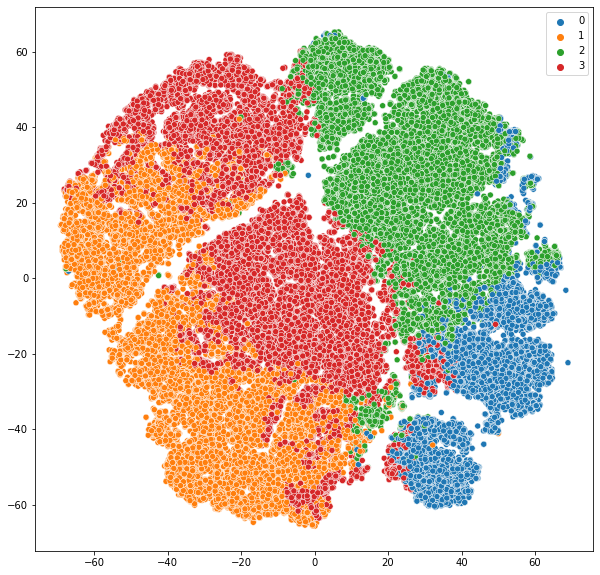

In [61]:
tsne = tsneViz(df_numeric, labels = KMeansAlgorithm.labels_ ,f_perplexity = 50.0, f_learning_rate = 500.0)

In [ ]:
## Label Data

In [ ]:
## Return and Classification Outliers